# Black-Box diffusion model advirsarial attack


In [ ]:
import torch
import pandas as pd
from google.colab import drive

Load prompt csv file:

In [ ]:
drive.mount('/content/gdrive')

df = pd.read_excel('/content/gdrive/MyDrive/black_box_project/Unorderd data for diffusion model.xlsx')

prompt_df = pd.concat([df.iloc[0::2].reset_index(drop=True), df.iloc[1::2].reset_index(drop=True)], axis=1)
prompt_df.columns = ["Dog_prompts", "Animal_prompts"]

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Diffusion model


Model ref: https://huggingface.co/stabilityai/stable-diffusion-3.5-medium


installs:


In [ ]:
# for diffusers
!pip install diffusers --upgrade
!pip install invisible_watermark transformers accelerate safetensors

In [ ]:
from huggingface_hub import notebook_login

notebook_login()


In [ ]:

from PIL import Image
import torch



from diffusers import DiffusionPipeline

pipe = DiffusionPipeline.from_pretrained("stable-diffusion-v1-5/stable-diffusion-v1-5")

prompt = "Astronaut in a jungle, cold color palette, muted colors, detailed, 8k"
image = pipe(prompt).images[0]

#pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-3.5-medium", torch_dtype=torch.float16, use_safetensors=True, variant="fp16")
pipe.to("cuda")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.31.0",
  "_name_or_path": "stable-diffusion-v1-5/stable-diffusion-v1-5",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [ ]:
prompt = ["The curious dog discovered a hidden treasure buried in the backyard", "The curious cat discovered a hidden treasure buried in the backyard"]
output = pipe(prompt=prompt).images

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

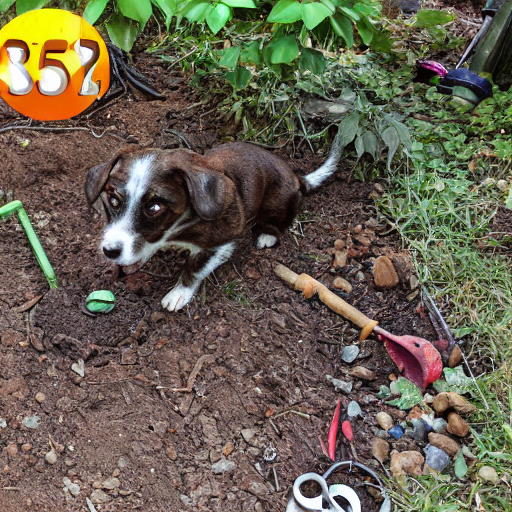

In [13]:
# Generate images
prompt = "The curious dog discovered a hidden treasure buried in the backyard"

output_images = pipe(prompt=prompt).images

# Display images

for img in output_images:
    display(img)

# pyGAD inference experiment- genetic algoritem

Installs:

In [14]:
# for diffusers
%%capture
!pip install diffusers --upgrade
!pip install invisible_watermark transformers accelerate safetensors
!pip install datasets
!pip3 install pygad

Imports:

In [15]:
import PIL
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch
import pandas as pd
import random
from tqdm import tqdm
import string
import numpy as np
import pygad
import torchvision.transforms.functional as F
from diffusers import DiffusionPipeline
from transformers import AutoImageProcessor, BitForImageClassification

In [ ]:
#@title Helper functions
## Functions:
def initilize_codes(code_population: int, code_length: int) -> list[str]:
    """The function initilize_codes generates a list of random alphanumeric strings, where the number of strings and their lengths are specified as parameters."""
    codes = []
    for _ in range(code_population):
      random_string = ''.join(random.choices(string.ascii_letters + string.digits, k=code_length))
      codes.append(random_string)

    return codes

def load_data(path: str):
    """This function load_data is designed to read data from an Excel file, process it into a structured format, and generate a list of random codes."""
    df = pd.read_excel(path)
    prompt_df = pd.concat([df.iloc[0::2].reset_index(drop=True), df.iloc[1::2].reset_index(drop=True)], axis=1)
    prompt_df.columns = ["Dog_prompts", "Animal_prompts"]
    codes = initilize_codes(code_population=code_population, code_length=code_length)
    return prompt_df, codes

def compute_scores(emb_one, emb_two):
    """Computes cosine similarity between two vectors."""
    scores = torch.nn.functional.cosine_similarity(emb_one, emb_two).cpu()
    return scores.numpy().tolist()

def fetch_similar(batch, top_k=5):
    """Fetches the `top_k` similar images with `image` as the query."""

    batch['loss'] = compute_scores(batch['dog_embeddings'], batch['animal_embeddings'])
    similarity_mapping = dict(zip(batch['code'], batch['loss']))

    # Sort the mapping dictionary and return `top_k` candidates.
    similarity_mapping_sorted = dict(sorted(similarity_mapping.items(), key=lambda x: x[1], reverse=True))
    code_entries = list(similarity_mapping_sorted.keys())[:top_k]

    return code_entries



In [ ]:
#@title Classes
## Classes:
class DiffusionAdversarialAttackDataset(torch.utils.data.Dataset):
    '''
    Input:
    Output: dataset[idx][dict] sorted by codes
    '''

    def __init__(self, prompts_df: pd.DataFrame, f=None, shuffle=False, batch_size=None, mode='testing', diffusion_model=None, embedding_model=None, trandform_embbedings_model=None):
        """prompts_df: DataFrame with two columns: "Animal_prompts" and "Dog_prompts".
        f: Optional, used later in custom collation for shuffling.
        shuffle: Boolean to decide whether to shuffle batches during collation.
        batch_size: Number of prompts processed at a time. Defaults to the size of prompts_df if not provided.
        mode: Determines how many rows of prompts_df to use. Defaults to 'testing', limiting rows to 2.
        diffusion_model, embedding_model, trandform_embbedings_model: Models used for generating images and embeddings.
        """
        super().__init__()
        self.end = 2 if mode == 'testing' else prompts_df.shape[0]
        self.shuffle = shuffle
        self.batch_size = prompts_df.shape[0] if batch_size==None else batch_size


        self.input_prompts, self.target_prompts = self.preprocess_prompts(prompts_df)

        if diffusion_model and embedding_model and trandform_embbedings_model:
            self.diffusion_model = diffusion_model
            self.embedding_model = embedding_model
            self.trandform_embbedings_model = trandform_embbedings_model
            self.dog_images, self.dog_embeddings = self.get_images_and_embeddings(self.target_prompts, self.batch_size, diffusion_model, embedding_model, trandform_embbedings_model)


    def __len__(self):
        return len(self.input_prompts)

    def __getitem__(self, idx):
        input_prompt = self.input_prompts[idx]
        target_prompt = self.target_prompts[idx]

        dog_images = self.dog_images[idx]
        dog_embeddings = self.dog_embeddings[idx]

        return {'input_prompt': input_prompt, 'target_prompt': target_prompt, 'dog_images': dog_images, 'dog_embeddings': dog_embeddings}

    def preprocess_prompts(self, prompts: pd.DataFrame) -> list[str]:
        animal_prompts = prompts.Animal_prompts.tolist()[:self.end]
        dog_prompts = prompts.Dog_prompts.tolist()[:self.end]
        #input_prompts = [self.remove_redundancies(prompt) for prompt in animal_prompts]
        #target_prompts = [self.remove_redundancies(prompt) for prompt in dog_prompts]
        #return input_prompts, target_prompts
        return animal_prompts, dog_prompts

    def get_images_and_embeddings(self, target_prompts, batch_size, diffusion_model, embedding_model, trandform_embbedings_model):
      #Generates images and embeddings for the target prompts:
        num_batches = (len(target_prompts) + batch_size - 1) // batch_size
        dog_images = []
        dog_embeddings = []
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, len(target_prompts))
            batch_chunk = target_prompts[start_idx:end_idx]

            if diffusion_model:
                batch_dog_images = diffusion_model.forward(batch_chunk)
                dog_images.extend(batch_dog_images)

            if embedding_model:
                if dog_images is not None:
                    x = embedding_model.forward(batch_dog_images)
                    batch_dog_embeddings = trandform_embbedings_model.forward(x)
                    dog_embeddings.append(batch_dog_embeddings)

        dog_embeddings = torch.cat(dog_embeddings, dim=0)

        return dog_images, dog_embeddings
      """
      לשאול את שחר למה זה קרה ? הרי יש משמעת סמנטית למשפט עם 2 חלקם. אם העניין זה חוסר יכולת חישובית להתמודד עם משפטיםארוכים פשוט מראש לא נבנה ככה את הדאטא בייס שלנו.
          def remove_redundancies(self, prompt: str) -> str:
              parts = prompt[::-1].split('.')
              return parts[1][::-1]
      """
    def custom_collate(self, batch):
        full_batch = {
            'animal_prompts': [item['input_prompt'] for item in batch],
            'dog_prompts': [item['target_prompt'] for item in batch],
            'dog_images': [item['dog_images'] for item in batch],
            'dog_embeddings': [item['dog_embeddings'] for item in batch],
        }

        if self.shuffle and f:
            random_indices = torch.randperm(len(batch))[:f]
            collated_batch = {
                'animal_prompts': [full_batch['animal_prompts'][i] for i in random_indices],
                'dog_prompts': [full_batch['dog_prompts'][i] for i in random_indices],
                'dog_images': [full_batch['dog_images'][i] for i in random_indices],
                'dog_embeddings': [full_batch['dog_embeddings'][i] for i in random_indices],
            }
        elif self.shuffle:
            random_indices = torch.randperm(len(batch))
            collated_batch = {
                'animal_prompts': [full_batch['animal_prompts'][i] for i in random_indices],
                'dog_prompts': [full_batch['dog_prompts'][i] for i in random_indices],
                'dog_images': [full_batch['dog_images'][i] for i in random_indices],
                'dog_embeddings': [full_batch['dog_embeddings'][i] for i in random_indices],
            }
        else:
            collated_batch = full_batch

        return collated_batch

class DiffusionPipeLine():
  #This class handles generating images using a pre-trained diffusion model (Stable Diffusion).
  def __init__(self, device: str):
      self.device = device

      self.model = DiffusionPipeline.from_pretrained(
          "stabilityai/stable-diffusion-xl-base-1.0",
          torch_dtype=torch.float16,
          use_safetensors=True,
          variant="fp16"
          )
      self.model.to(self.device)

  def forward(self, batch: list):
      with torch.no_grad(): # Was added
          batch_images = self.model(batch).images
      return batch_images

class ImageEmbeddingPipeline():
  def __init__(self, device: str):
      self.device = device
      #בעצם קוראים למודל ספציפי שמבוסס על רס נט, ומשתמשים בו לקבלת האימבדד של התמונה, למה להשתמש ברסנט ולא בקליפ?
      #שינוי להמשך: לשקול לשנות את הקלאס ככה שיקבל בכניסה שם של מודל אימבדד ואז נוכל לעשות ניסוים עם מודלי אימבדד שונים לדוגמה קליפ.
      self.image_processor = AutoImageProcessor.from_pretrained("google/bit-50")
      self.model = BitForImageClassification.from_pretrained("google/bit-50")
      self.model.config.output_hidden_states = True
      self.model.to(self.device)

  def forward(self, batch: dict):
      embeddings = self.get_embeddings(batch)
      return embeddings

  def get_embeddings(self, batch: list):
      images = batch

      image_batch_transformed = self.image_processor(images, return_tensors="pt").to(self.device)
      with torch.no_grad():
          embeddings = self.model(**image_batch_transformed).hidden_states[-1]
      return embeddings

class TransformForCostFunction(torch.nn.Module):
  def __init__(self, projection_head: bool, device: str):
      super().__init__()
      self.projection_head = True if projection_head else False
      self.device = device

      if self.projection_head:
         pass # Add projection head from swav
      else:
        self.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))

      self.to(self.device)

  def forward(self, batch: dict):
      batch_transformed = self.transform(batch)
      return batch_transformed

  def transform(self, last_hidden_states):
      if self.projection_head:
        return last_hidden_states # Add projection head from swav
      else:
        x = self.avgpool(last_hidden_states)
        x = torch.flatten(x, 1)
      return x

In [ ]:
#@title Classes Before Memory Adjustments
## Classes:
class DiffusionAdversarialAttackDataset(torch.utils.data.Dataset):
    '''
    Input:
    Output: dataset[idx][dict] sorted by codes
    '''

    def __init__(self, prompts_df: pd.DataFrame, f=None, shuffle=False, batch_size=None, mode='testing', diffusion_model=None, embedding_model=None, trandform_embbedings_model=None):
        super().__init__()
        self.end = 1 if mode == 'testing' else prompts_df.shape[0]
        self.shuffle = shuffle
        self.batch_size = prompts_df.shape[0] if batch_size==None else batch_size


        self.input_prompts, self.target_prompts = self.preprocess_prompts(prompts_df)

        if diffusion_model and embedding_model and trandform_embbedings_model:
            self.diffusion_model = diffusion_model
            self.embedding_model = embedding_model
            self.trandform_embbedings_model = trandform_embbedings_model
            self.dog_images, self.dog_embeddings = self.get_images_and_embeddings(self.target_prompts, self.batch_size)


    def __len__(self):
        return len(self.input_prompts)

    def __getitem__(self, idx):
        input_prompt = self.input_prompts[idx]
        target_prompt = self.target_prompts[idx]

        dog_images = self.dog_images[idx]
        dog_embeddings = self.dog_embeddings[idx]

        return {'input_prompt': input_prompt, 'target_prompt': target_prompt, 'dog_images': dog_images, 'dog_embeddings': dog_embeddings}

    def preprocess_prompts(self, prompts: pd.DataFrame) -> list[str]:
        animal_prompts = prompts.Animal_prompts.tolist()[:self.end]
        dog_prompts = prompts.Dog_prompts.tolist()[:self.end]
        input_prompts = [self.remove_redundancies(prompt) for prompt in animal_prompts]
        target_prompts = [self.remove_redundancies(prompt) for prompt in dog_prompts]
        return input_prompts, target_prompts

    def get_images_and_embeddings(self, target_prompts, batch_size):
        num_batches = (len(target_prompts) + batch_size - 1) // batch_size
        dog_images = []
        dog_embeddings = []
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, len(target_prompts))
            batch_chunk = target_prompts[start_idx:end_idx]

            if self.diffusion_model:
                batch_dog_images = self.diffusion_model.forward(batch_chunk)
                dog_images.extend(batch_dog_images)

            if self.embedding_model:
                if dog_images is not None:
                    x = self.embedding_model.forward(batch_dog_images)
                    batch_dog_embeddings = self.trandform_embbedings_model.forward(x)
                    dog_embeddings.append(batch_dog_embeddings)

        dog_embeddings = torch.cat(dog_embeddings, dim=0)

        return dog_images, dog_embeddings

    def remove_redundancies(self, prompt: str) -> str:
        parts = prompt[::-1].split('.')
        return parts[1][::-1]

    def custom_collate(self, batch):
        full_batch = {
            'animal_prompts': [item['input_prompt'] for item in batch],
            'dog_prompts': [item['target_prompt'] for item in batch],
            'dog_images': [item['dog_images'] for item in batch],
            'dog_embeddings': [item['dog_embeddings'] for item in batch],
        }

        if self.shuffle and f:
            random_indices = torch.randperm(len(batch))[:f]
            collated_batch = {
                'animal_prompts': [full_batch['animal_prompts'][i] for i in random_indices],
                'dog_prompts': [full_batch['dog_prompts'][i] for i in random_indices],
                'dog_images': [full_batch['dog_images'][i] for i in random_indices],
                'dog_embeddings': [full_batch['dog_embeddings'][i] for i in random_indices],
            }
        elif self.shuffle:
            random_indices = torch.randperm(len(batch))
            collated_batch = {
                'animal_prompts': [full_batch['animal_prompts'][i] for i in random_indices],
                'dog_prompts': [full_batch['dog_prompts'][i] for i in random_indices],
                'dog_images': [full_batch['dog_images'][i] for i in random_indices],
                'dog_embeddings': [full_batch['dog_embeddings'][i] for i in random_indices],
            }
        else:
            collated_batch = full_batch

        return collated_batch

class DiffusionPipeLine():
  def __init__(self, device: str):
      self.device = device

      self.model = DiffusionPipeline.from_pretrained(
          "stabilityai/stable-diffusion-xl-base-1.0",
          torch_dtype=torch.float16,
          use_safetensors=True,
          variant="fp16"
          )
      self.model.to(self.device)

  def forward(self, batch: list):
      batch_images = self.model(batch).images
      return batch_images

class ImageEmbeddingPipeline():
  def __init__(self, device: str):
      self.device = device

      self.image_processor = AutoImageProcessor.from_pretrained("google/bit-50")
      self.model = BitForImageClassification.from_pretrained("google/bit-50")
      self.model.config.output_hidden_states = True
      self.model.to(self.device)

  def forward(self, batch: dict):
      embeddings = self.get_embeddings(batch)
      return embeddings

  def get_embeddings(self, batch: list):
      images = batch

      image_batch_transformed = self.image_processor(images, return_tensors="pt").to(self.device)
      with torch.no_grad():
          embeddings = self.model(**image_batch_transformed).hidden_states[-1]
      return embeddings

class TransformForCostFunction(torch.nn.Module):
  def __init__(self, projection_head: bool, device: str):
      super().__init__()
      self.projection_head = True if projection_head else False
      self.device = device

      if self.projection_head:
         pass # Add projection head from swav
      else:
        self.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))

      self.to(self.device)

  def forward(self, batch: dict):
      batch_transformed = self.transform(batch)
      return batch_transformed

  def transform(self, last_hidden_states):
      if self.projection_head:
        return last_hidden_states # Add projection head from swav
      else:
        x = self.avgpool(last_hidden_states)
        x = torch.flatten(x, 1)
      return x

Set parameters:

In [ ]:
# Genetic Algorithm
code_length = 10 # m in the paper
code_population = 1 # n in the paper

# parameters
seed = 42
prompt_path = "/content/drive/MyDrive/master degree/תזה/Attack on diffusion model/Unorderd data for diffusion model.xlsx"
f=50 # f=50 in the paper
# elitists = torch.ceil(code_population/5) # lambda(elitists) = n/5 in the paper
# k = 2 # tournament selection factor k=2 in the paper

# Reproducibility
random.seed(seed)
torch.manual_seed(seed)

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

play to save modle parameters

In [ ]:
import pickle
# Save a variable
#with open('/content/gdrive/MyDrive/variables.pkl', 'wb') as f:pickle.dump(my_variable, f)
# Save Stable Diffusion model
pipe.save_pretrained('/content/gdrive/MyDrive/stable_diffusion_model')
image.save('/content/gdrive/MyDrive/output.png')
!pip freeze > /content/gdrive/MyDrive/requirements.txt


play to load modle parameters

In [9]:
from google.colab import drive
drive.mount('/content/gdrive')
#with open('/content/gdrive/MyDrive/variables.pkl', 'rb') as f: my_variable = pickle.load(f)
from diffusers import DiffusionPipeline
pipe = DiffusionPipeline.from_pretrained('/content/gdrive/MyDrive/stable_diffusion_model')
pipe.to("cuda")
from PIL import Image
image = Image.open('/content/gdrive/MyDrive/output.png')
image.show()
!pip install -r /content/gdrive/MyDrive/requirements.txt --no-deps


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  Using cached https://pypi.nvidia.com/cudf-cu12/cudf_cu12-24.10.1-cp310-cp310-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl (24.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 98.7 MB/s eta 0:00:00
  Using cached https://pypi.nvidia.com/libcudf-cu12/libcudf_cu12-24.10.1-py3-none-manylinux_2_28_x86_64.whl (515.1 MB)
  Using cached https://pypi.nvidia.com/nx-cugraph-cu12/nx_cugraph_cu12-24.10.0-py3-none-any.whl (149 kB)
  Using cached https://pypi.nvidia.com/pylibcudf-cu12/pylibcudf_cu12-24.10.1-cp310-cp310-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl (20.5 MB)
  Using cached https://download.pytorch.org/whl/cu121_full/torch-2.5.1%2Bcu121-cp310-cp310-linux_x86_64.whl (2370.5 MB)
  Using cached https://download.pytorch.org/whl/cu121/torchaudio-2.5.1%2Bcu121-cp310-cp310-linux_x86_64.whl (3.4 MB)
  Using cached https://download.pytorch.org/whl/cu121/torchvision-0.20.1%2Bcu121-cp310-cp310-linux_x86_64.whl (7.3 MB)
  Using cached datasets-3.1.0-py3-none-any.whl.metadata